# Predicting School Closures Based on Inspection Reports with Deep Learning
We scraped school inspection reports from [Ofsted](https://reports.ofsted.gov.uk) in an attempt to predict whether or not a school is in danger of closing. In this notebook, we take a deep learning approach to a Natural Language Processing (NLP) problem. This notebook applies [fast.ai's transfer learning](https://www.fast.ai/2019/07/08/fastai-nlp/) approach by training a language model (we'll get into what that is soon) on a large corpus of school reports. This model is then used to help our classifier predict whether or not a report contains some indication that the school will close.

The logic behind our approach was to separate all of the final reports of schools that have already closed. The idea behind this was that these reports may contain some information as to why the school would close. We labeled these reports `last`, while all other reports were labeled `not_last`.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [62]:
df = pd.read_csv('/picstorage/last_reports.csv')

In [63]:
df = df.drop('Unnamed: 0',axis=1)

## About the Dataset
We filtered out some of the reports we scraped that had certain characteristics that we thought were not relevant to the problem we were trying to solve. Here are some of the reports we didn't include in our dataset: 
- Childminders: daycares in an individual's home who can care for up to six children at a time, including their own. Childminders are not necessarily academic institutions, so we have filtered them out.
- Nurseries
- Children's homes

Also, it is important to note that [Ofsted does not continue to inspect schools once they are known for being Outstanding](https://www.bbc.com/news/education-48635078). Our data does not account for whether an Outstanding school has deteriorated in quality after its last inspection.

In [64]:
df.head()

,school,text,file,label
0,Oldfield School Closed,26/04/2011 Dear Parent Oldfield Sch...,1560129,last
1,Settle Church of England Voluntary Controlled ...,School report Settle Church of England Volunt...,2542866,last
2,Whitmore Park Annexe Closed,School report Whitmore Park Annexe Rylst...,50051929,last
3,Da Vinci Community School Closed,Ofsted Piccadilly Gate Store Street Manchester...,2559726,last
4,Amazing Allstars Out Of School Club Closed,Amazing Allstars Out Of School Club 2nd...,2732121,last


In [65]:
len(df[df['label'] == 'not_last'])
not_last = df[df['label'] == 'not_last']

227183

In [66]:
len(df[df['label'] == 'last'])
last = df[df['label'] == 'last']

62556

## Imbalanced Dataset
Our dataset has a pretty uneven class distribution, and only about 1/5 of our dataset has the `last` label. This poses a bit of a problem later on when we want to evaluate how well our classifier is doing. Accuracy is usually a common metric to evaluate a model, but it's not the best way to evaluate a model trained on an imbalanced dataset. For example, in our case, if the classifier were to guess that 100% of the samples we give it are `not_last`, it would have a pretty decent accuracy of 80%. However, this classifier would be doing pretty poorly in reality. 

There are a few ways to measure the performance for an imbalanced dataset other than accuracy, and we'll look into our model's *precision* and *recall* later on to tell us how it's doing. We've included the `f_beta` metric For now, which evaluates an F1 score that takes the weighted average of precision and recall.  

In our problem, we decided to keep the dataset imbalanced to better reflect the distribution of reports in reality. Since the number of reports that aren't final reports greatly outweighs the number of final reports in our real-life problem, I wanted my classifier to reflect this situation.

In [68]:
# for a balanced dataset
not_last_sample = not_last.sample(1000)
last_sample = last.sample(1000)

In [70]:
subset = pd.concat([not_last_sample,last_sample],ignore_index=True)

In [71]:
# for an imbalanced dataset
# subset = df.sample(2000)
train = subset.sample(1500)
test = subset[~subset.isin(train)].dropna()
test['file'] = test['file'].astype(int)

In [3]:
# train.to_csv('/picstorage/lr_train_sample_even.csv',index=False)
train = pd.read_csv('/picstorage/last_report_train_sample.csv')
train = train.drop('Unnamed: 0',axis=1)
train.head()

,school,text,file,label
0,Denholme Primary School Closed,Denholme Primary School Inspection report ...,1964405,not_last
1,North Cornwall Short Stay School Closed,OfstedPage 1 of 5Tribal Group1-4 Portland Squa...,858483,not_last
2,Glenwood School,UntitledGlenwood SchoolInspection report115469...,926591,not_last
3,"Salisbury, Manor Fields Primary School",Manor Fields Primary SchoolInspection report.■...,974545,not_last
4,St Ambrose Catholic Primary School,St Ambrose Catholic Primary School Inspecti...,1975093,not_last


In [4]:
test = pd.read_csv('/picstorage/last_report_test_sample.csv')
test = test.drop('Unnamed: 0',axis=1)
test.head()

,school,text,file,label
0,URN: SC412705,Unique reference number SC412705 Vis...,2416777,not_last
1,Fig Tree Primary School,School report Fig Tree Primary School 30...,2734435,not_last
2,Askham Bar Day Nursery,Askham Bar Day N...,1796701,not_last
3,Victoria Road Primary School,School report Victoria Road Primary School...,2243241,not_last
4,Barnkids Ltd,Barnkids Ltd Ins...,1824169,not_last


In [77]:
test.to_csv('/picstorage/lr_test_sample_even.csv',index=False)

In [18]:
print ("printing len of train: {}".format(len(train)))
print ("printing len of test: {}".format(len(test)))

printing len of train: 1500
printing len of test: 500


In [11]:
print ("printing last reports in train: {}".format(len(train[train['label'] == 'last'])))
print ("printing not last reports in train: {}".format(len(train[train['label'] != 'last'])))
print ("printing last reports in test: {}".format(len(test[test['label'] == 'last'])))
print ("printing not last reports in test: {}".format(len(test[test['label'] != 'last'])))

printing last reports in train: 307
printing not last reports in train: 1193
printing last reports in test: 105
printing not last reports in test: 395


## Making a language model
The code for our language model is in `nbs/data_model.py`. We trained our language model on our entire corpus of 289,739 inspection reports. This took about 3 days to train and the databunch we used was about 3GB large. We've provided a sample language model databunch in `nbs/data_lm.pkl` that was trained on a smaller subset of reports and is only about 33MB large. 

### What is a language model?
A language model is a probability distribution over sequences of words that tries to predict what the next word of a sentence or phrase would be. For a more in-depth overview as to how language models work, you can refer to [these slides](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf) from Stanford University's Computer Science department.

### Language Model Encoder
After your language model is done training, save its encoder. The encoder will later be used to help our classifier interpret reports.

In [5]:
np.random.seed(42)
data_lm = load_data('/picstorage/', 'data_lm.pkl', bs=12)

/tmp/yes/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


If you encounter issues loading the language model on your machine, try decreasing the batch size.

In [6]:
bs=12

In [7]:
data_lm.show_batch()

idx,text
0,school total xxmaj government funded early educationprovision for aged to endof xxup eyfs xxmaj childcare provision for aged to yearsthe erning bodyappropriate authoritybarrie keastchakeith purvisheadteachernot previously inspecteddate of previous xxmaj not previously inspecteddate of previous funded early education xxmaj not previously inspecteddate of previous childcare xxmaj bank roadschool addresspilningbristolbs xxup jg xxmaj telephone number xxmaj fax number xxmaj age group xxmaj october xxmaj inspection dates xxmaj inspection number xxmaj crown
1,is clear guidance for everyone participating in activities and thisensures that focus and intentions are similar and shared xxmaj all six areas of are thoroughly covered xxmaj staff work hard to create realistic links between xxunk that can explore an idea in many different contexts xxmaj consequently understanding is greatly enhanced xxmaj early in year much of revolves around imaginative role play xxmaj later in year for part of each
2,xxunk on a xxmaj wednesday session is extended to enable to bring lunch xxmaj the nursery is able to use adjoining vicarage garden for outdoor play xxmaj there are two full time and six part time working with xxmaj two members have relevant child care qualifications and two are currently ontraining programmes xxmaj how is xxmaj day xxmaj care xxmaj the xxmaj greenery xxmaj nursery xxmaj school provides care for
3,adult and that y will be sorted quickly xxmaj nearly all comment that re is no bullying in xxmaj the very few who commented that bullying sometimes happens are adamant that teachers are really at resolving it xxmaj this means that enjoy time at and all stated that y would recommend to a friend moving to area xxmaj parents are confident that are kept safe and are extremely well looked
4,at home xxmaj partnerships with parents are very xxmaj parents comment on positive changes since last xxmaj staff provide an effective range of appropriately challenging experiences xxmaj children s confidence is nurtured and is extended when y are ready xxmaj they make progress from when y begin to attend xxmaj staff get to know individual extremely well xxmaj the key person system is highly effective xxmaj children share strong emotional


In [8]:
gc.collect()

74

## Preparing Our Data for Classification
Once we have our language model, we need to separate our data into our training and validation sets. Fast.ai handles this for us through its `DataBunch` class. Below, we use a [`TextClasDataBunch`](https://docs.fast.ai/text.data.html#TextClasDataBunch) for our text classification problem and load the data from our dataframes. We also specify that the vocabulary of our DataBunch is the vocabulary of our language model.

In [9]:
data_clas = TextClasDataBunch.from_df(path='', train_df=train, valid_df=test, vocab=data_lm.vocab, 
                                       text_cols='text', label_cols='label')

In [19]:
data_clas.save('/picstorage/data_clas.pkl')

In [13]:
data_clas = load_data('', '/picstorage/data_clas.pkl', bs=bs)

In [14]:
data_clas.show_batch()

text,target
xxbos xxup xxunk xxup xxunk xxup woods xxunk xxunk londonlea area xxunk xxunk xxunk reference number xxunk xxunk xxunk xxmaj michael xxunk inspector xxunk xxmaj brian xxunk of inspection xxunk 7 xxunk xxunk xxmaj october xxunk number xxunk xxunk inspection carried out under section xxunk of the xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part for non,not_last
xxbos xxup xxunk xxup xxunk xxup community xxunk area xxunk cornwallunique reference number xxunk xxunk xxunk xxmaj miss xxmaj janet xxunk inspector xxunk xxmaj john xxunk of inspection xxunk xxunk xxunk xxunk xxmaj march xxunk number xxunk xxunk carried out under section xxunk of the xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part for non xxunk commercial,not_last
xxbos xxup xxunk xxup report xxup princes xxup xxunk xxup school xxmaj princes xxmaj xxunk xxup lea area xxunk xxmaj xxunk xxmaj unique reference number xxunk xxunk xxmaj acting xxmaj headteacher xxunk xxmaj mrs s xxmaj gates xxmaj lead inspector xxunk xxmaj mrs j xxmaj greenfield xxmaj dates of inspection xxunk xxunk xxunk xxunk xxmaj september xxunk xxmaj inspection number xxunk xxunk xxmaj inspection carried out under section xxunk of,not_last
xxbos xxup xxunk xxup inspection xxup report xxup xxunk xxup primary xxup school xxmaj xxunk xxunk xxmaj nr xxmaj melton xxmaj mowbray xxup lea area xxunk xxmaj xxunk xxmaj unique reference number xxunk xxunk xxmaj headteacher xxunk xxmaj mrs a xxmaj wright xxmaj reporting inspector xxunk xxmaj mrs h xxmaj xxunk xxunk xxmaj dates of inspection xxunk xxmaj july xxunk xxunk xxunk xxunk xxmaj inspection number xxunk xxunk xxmaj inspection,not_last
xxbos xxup xxunk xxup reportthe xxup xxunk xxup xxunk xxup xxunk area xxunk dorsetunique reference number xxunk xxunk xxunk xxmaj mr xxmaj xxunk xxunk inspector xxunk xxmaj michael xxunk of inspection xxunk xxunk xxunk xxunk xxmaj march xxunk number xxunk xxunk carried out under xxmaj section xxunk of the xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part,not_last


In [18]:
data_clas.vocab.itos = data_lm.vocab.itos

## Creating our Learner
The Learner is what we'll use to train our model, which is in this case is [`AWD_LSTM`](https://docs.fast.ai/text.models.html#AWD_LSTM). AWD_LSTM is a type of RNN, or Recurrent Neural Network, that is available through fast.ai. 

### What's a neural network?
Before giving an overview about RNNs, we're going to take a step back and go over what a neural network is. Loosely inspired by neurons in the human brain, neural networks consist of nodes, which on a very high level take in a set of inputs and modify them to produce an output. These inputs are modified by weights or coefficients that either amplify or dampen the input, depending on how important the information is relative to what the algorithm is trying to learn. After the products of the inputs and weights are found, these products are summed and passed through an activation function, which helps decide what the output should be. There are several types of activation functions, and you generally need to remember that they are some sort of mathematical equation. We won't dive into the math here, but you can refer to [this guide to get a sense of the activation functions that are out there](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6). In the context of a classification problem, the activation function of a node can help decide which class the sample we inserted belongs to. The inputs, in this case, would be a vector that represents the sentence of interest in mathematical form. There are several methods to vectorize text, but on a high level, this step is essentially converting words into a mathematical representation so that they can be multiplied by the weights each node. A neural network consists of several rows of neurons, where the input of one layer is the output of the previous layer. This is a *very* high level explanation, and there are several aspects of neural networks that we have not covered. To learn more about neural nets, you can refer to [this resource published by Skymind](https://skymind.com/wiki/neural-network) and this [free online book](http://neuralnetworksanddeeplearning.com/index.html) that takes a more hands-on approach.

Now that we have a basic overview of what a neural network is, an RNN is a type of neural network that remembers its past decisions, and the decisions it makes are influenced by what it has learned from the past. RNNs are influenced not just by the weights applied to inputs, but also by a "hidden" state vector that provides context about prior inputs and outputs. Because they account for past decisions, RNNs are commonly used in Natural Language Processing, or NLP, because they can recall patterns of words that it previously learned. There are several types of RNNs, and the one we use here is a Long SHort-Term Memory Unit, or LSTM. To learn more, you can refer to [this resource published by Skymind.](https://skymind.com/wiki/lstm)

### How do I get started using a neural network?
In the context of fast.ai's text library, you just need to note that the model you are using is an RNN called the AWD_LSTM. You can get started using this algorithm the same way we do in the cell below by including it as a parameter for our learner.

### How do I choose the type of learner I need?
Since this is a text classification problem, we can go ahead and use fast.ai's [`text_classifier_learner`](https://docs.fast.ai/text.learner.html#text_classifier_learner) method to get started quickly. The type of learner you choose depends on the problem you are working with. For example, in `nbs/data_lm.py`, we used a [`language_model_learner`](https://docs.fast.ai/text.learner.html#language_model_learner) to create an RNN that would be able to recognize patterns of phrasing in our corpus. With our text_classifier_learner, we want an RNN that would be able to associate certain reports and phrasings with a given class. In this case, our classes are `last` and `not_last`.

In [10]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) 
# Above, we insert our DataBunch, RNN, and specify dropout
encoder_name = '/home/ubuntu/aistudio-schools/models/bs60-awdlstm-enc-stage2'
classifier.load_encoder(encoder_name)

### What's dropout?
Dropout is a regularization technique that addresses *overfitting*. Dropout entails temporarily ignoring randomly selected nodes during training. This helps because it prevents nodes from becoming dependent on each other during training. 

### What's overfitting?
Overfitting occurs when the model is fitting the training data too well and is learning things that are not generalizable. In other words, what it is learning is specific to the training data. Another type of statistical fit is underfitting. Underfitting occurs when a model can neither model the training data nor make a generalizable model. A model is overfitting when its training loss is significantly *lower* than its validation loss. Conversely, a model is underfitting when its training loss is significantly *greater* than its validation loss. 

### How do I adjust for overfitting or underfitting?
If you're overfitting, you can adjust the dropout by increasing the `drop_mult` parameter of your learner. If you're underfitting, you can decrease this parameter. 

You can also adjust the weight decay (`wd`) of your model. Models with more parameters tend to overfit and have a high variance. By increasing weight decay, we penalize complexity by encouraging our model to have less parameters. In fast.ai, `wd = 0.1` generally works well, and the default is `wd = 0.01`.

In [20]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


## Choosing a Learning Rate
A unique feature of fast.ai is that we can choose the learning rate at which our model trains. This helps us fine tune our model based on what seems to yield the highest accuracy. You typically want to choose a learning rate that is approximately in the middle of the steepest downward slope. If you need some help choosing a learning rate, you can always use `classifier.recorder.plot(suggestion=True)`.

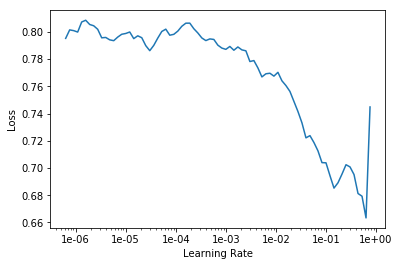

In [21]:
classifier.recorder.plot()

In [32]:
classifier.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.400123,0.345092,0.886000,21:32


## Fine Tuning
Our classifier did decently well after training with one epoch at a learning rate of 1e-3. We can save our trained model and freeze certain layers to fine tune to try to improve the model's accuracy.

### What is freezing?
When you freeze layers in fast.ai, you make the weights of earlier layer groups unchangeable. The point of this is to retain what the model has already learned about basic representations. The last few layer groups are left unfrozen so that they can learn representaitons specific to your tax.

In [33]:
classifier.save('last-reports1-july30')

In [34]:
classifier.load('last-reports1-july30')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

In [35]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.386272,0.356741,0.884000,19:11


In [36]:
classifier.save('last-reports2-july29')

In [12]:
classifier.load('last-reports2-july29')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

## Checking the Precision of Our Model
As we said before, our dataset is imbalanced, so accuracy is not a good measure of our model's effectiveness. Precision refers to how close predictions from different samples are to each other. Below, we use `average_precision_score` from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). A single precision score is evaluated as `tp / (tp + fp)` where `tp` stands for *true positives* and `fp` stands for *false positives*. Average precision summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold. The increase in recall from the previous threshold is used as a weight. Recall measures the model's ability to find all relevant results that are correctly classified by your algorithm. Recall is the ratio `tp / (tp + fn)` where `tp` stands for *true positives* and `fn` stands for *false negatives*.

In [13]:
preds = classifier.get_preds()

In [53]:
classifier.data.classes

['last', 'not_last']

In [14]:
not_last_prob = [prob[1].item() for prob in preds[0]] 
# Get the probability that it's not a last report

In [15]:
last_prob = [prob[0].item() for prob in preds[0]]

We can see that our precision for prediction that a report is not a final report is decently high.

In [82]:
from sklearn.metrics import average_precision_score
average_precision_score(preds[1],not_last_prob) # avg precision if it's not last

0.9667174566352743

## More Training

In [17]:
classifier.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.321394,0.344507,0.882000,07:00
1,0.331036,0.330025,0.882000,06:32
2,0.328994,0.324024,0.882000,06:24
3,0.326688,0.328477,0.884000,06:47


In [20]:
classifier.save('last-reports3-july29')

In [21]:
classifier.load('last-reports2-july29')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

In [22]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.341179,0.319667,0.882000,07:01
1,0.327932,0.372058,0.872000,07:16


## Trying a Few Test Samples
You can manually input a few test samples to see how your classifier is doing. I have included a few reports that were not included in our training set.

In [45]:
file = open('text-only/testing-files/2615997.txt','r').read()
classifier.predict(file) # should be a final report

(Category last, tensor(0), tensor([0.6858, 0.3142]))

In [46]:
file2 = open('text-only/testing-files/937333.txt','r').read() 
classifier.predict(file2) # Should not be a final report

(Category not_last, tensor(1), tensor([0.1163, 0.8837]))

## Better Understanding Your Model
Fast.ai also has a feature that allows you to see which words your classifier finds informative in making its prediction. The class that allows you to do this is [`TextClassificationInterpretation`](https://docs.fast.ai/text.learner.html#TextClassificationInterpretation). 

In [47]:
import matplotlib.cm as cm
txt_ci = TextClassificationInterpretation.from_learner(classifier)

In [48]:
txt_ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos xxup combined xxup inspection xxup reporturn xxunk xxmaj number xxunk xxup xxunk detailsinspection xxmaj date xxunk xxunk xxunk xxunk xxunk xxmaj name xxmaj liz xxunk detailsday xxmaj care xxmaj type xxmaj full xxmaj day caresetting xxmaj name xxmaj two xxmaj willows xxmaj early xxmaj years xxmaj centre xxunk xxmaj community centresetting xxmaj address xxmaj cardinal xxunk xxunk xxup xxunk xxup provider detailsname xxmaj early xxmaj years xxunk detailsname xxmaj,not_last,not_last,8.25,1.00
xxbos xxup tsc xxmaj report templatet r a i n i n g s t a n d a r d s c o u n c i xxup li n s p e c t i o n r e p o r t n o v e m b e r xxunk 9 9 xxup xxunk e i n s p e c t i o n f,not_last,not_last,8.07,1.00
xxbos xxunk xxmaj steiner schoolindependent school progress reportdcsf registration number xxunk xxunk xxunk xxmaj reference xxmaj number xxunk xxup urn xxunk xxunk number xxunk dates 8 xxmaj june xxunk inspector xxmaj mick xxunk xxunk xxmaj june xxunk xxmaj office for xxmaj standards in xxmaj education xxunk xxmaj children xxunk xxmaj services and xxmaj skills xxunk xxmaj ofsted xxunk regulates and inspects to achieve excellence in the care of children and,not_last,last,3.99,0.02
xxbos xxmaj school report xxmaj xxunk xxmaj primary xxmaj school xxmaj xxunk xxmaj road xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxmaj merseyside xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxmaj march xxunk xxmaj overall effectiveness xxmaj good xxmaj effectiveness of leadership and management xxmaj outstanding xxmaj quality of teaching xxunk learning and assessment xxmaj good xxmaj personal development xxunk behaviour and welfare xxmaj outstanding xxmaj outcomes for pupils,not_last,not_last,3.82,0.98
xxbos xxmaj la xxmaj xxunk xxmaj school xxmaj independent school standard inspection report dfe registration number xxunk xxunk xxunk xxmaj unique xxmaj reference xxmaj number xxunk xxup urn xxunk xxunk xxup urn for registered childcare xxup xxunk xxmaj inspection number xxunk xxmaj inspection dates xxunk xxmaj december xxunk xxmaj reporting inspector xxmaj flora xxmaj bean xxmaj the xxmaj office for xxmaj standards in xxmaj education xxunk xxmaj children xxunk xxmaj,not_last,not_last,3.74,0.98
xxbos xxunk xxunk xxmaj st xxmaj mary xxmaj church of englandprimary xxunk xxmaj reference xxunk xxunk xxunk xxmaj november xxunk xxunk yatesreporting inspectorthis inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk addressprimarytype of xxunk xxunk xxunk aidedschool xxunk xxunk xxup xxunk xxunk range of xxunk xxunk numbermixedgender of xxunk xxunk xxunk on roll xxunk xxunk xxmaj peter xxunk governing bodyappropriate,not_last,not_last,3.66,0.97
xxbos xxmaj ofsted xxmaj piccadilly xxmaj gate xxmaj store xxmaj street xxmaj manchester xxup xxunk xxup xxunk t xxunk xxunk xxunk xxunk xxunk ofsted xxunk xxmaj october xxunk xxmaj anthony xxmaj thomas xxmaj headteacher xxmaj edwalton xxmaj primary xxmaj school xxmaj wellin xxmaj lane xxmaj edwalton xxmaj nottingham xxmaj xxunk xxup xxunk xxup xxunk xxmaj dear xxmaj mr xxmaj thomas xxmaj short inspection of xxmaj edwalton xxmaj primary xxmaj school,not_last,last,3.46,0.03
xxbos xxmaj kidzone xxmaj astley xxmaj xxunk xxmaj stephens c of e xxmaj primary xxmaj school xxunk xxmaj manchester xxmaj road xxunk xxmaj astley xxunk xxmaj tyldesley xxunk xxmaj manchester xxunk xxup xxunk xxup xxunk xxmaj inspection date xxmaj previous inspection date xxunk xxmaj february xxunk xxunk xxmaj september xxunk xxmaj the quality and standards of the early years provision xxmaj this inspection xxunk xxmaj not met xxmaj previous inspection,not_last,not_last,3.44,0.97
xxbos xxmaj school report xxmaj the xxmaj cedar xxmaj centre xxmaj xxunk xxmaj close xxunk xxmaj xxunk xxunk xxmaj brighton xxunk xxmaj east xxmaj sussex xxunk xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxmaj november xxunk xxmaj overall effectiveness xxmaj previous inspection

Informative words are highlighted in purple in the examples below. The more important the word is to the classifier, the darker the shade of purple.

In [49]:
txt_ci.show_intrinsic_attention(file,cmap=cm.Purples)

In [50]:
txt_ci.show_intrinsic_attention(file2,cmap=cm.Purples)

In [23]:
classifier.save('last-reports4-july29')

In [24]:
classifier.load('last-reports4-july29')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


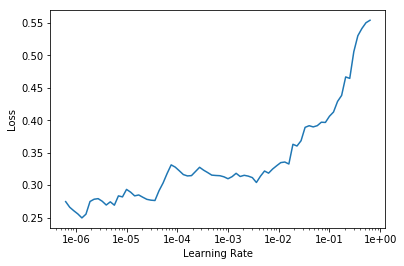

In [53]:
# More training
classifier.lr_find()
classifier.recorder.plot()

In [25]:
# Choose a learning rate at train it for 4 epochs
classifier.freeze_to(-2)
classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.329040,0.340213,0.868000,06:59
1,0.308030,0.342456,0.884000,07:16


In [58]:
# Add to print out words that the classifier gains the most info from
idx = 4
print(classifier.predict(str(classifier.data.valid_ds.x[idx])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.0239, 0.9761]))


## Evaluating a Model with an Imbalanced Dataset
Along with precision and recall, we can also make a confusion matrix to better understand how our model is doing. Our confusion matrix below was built with the validation set that we handed to our classifier in the beginning (which was in `test.csv`).

We can break down the visualization below by defining a few basic terms. For our examples, let's assume that our positive label is `not_last`. 
- **true positives (tp)**: Our model predicted that a sample was the positive label, and this prediction was correct. (tp=365)
- **true negatives (tn)**: Our model predicted that a sample was not the positive label, and this prediction was correct. (tn=77)
- **false positives (fp)**: Our model predicted that a sample was the positive label, and this prediction was incorrect. (fp=28)
- **false negatives (fn)**: Our model predicted that a sample was not the positive label, and the prediction was incorrect. (fn=30)

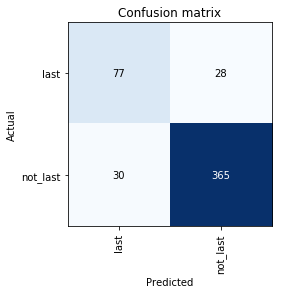

In [59]:
from fastai.vision import ClassificationInterpretation
interp2 = ClassificationInterpretation.from_learner(classifier)
interp2.plot_confusion_matrix()

In [71]:
preds = classifier.get_preds()

In [81]:
len(preds[0])
len(preds[1])
len(classifier.data.valid_ds)

500

500

500

In [27]:
classifier.data.classes

['last', 'not_last']

In [73]:
not_last_prob = [prob[1].item() for prob in preds[0]] 
# Get the probability that it's nota last report

In [74]:
last_prob = [prob[0].item() for prob in preds[0]]

In [75]:
from sklearn.metrics import recall_score
average_precision_score(preds[1],not_last_prob) # avg precision if it's not last

0.9541119363872355

In [76]:
average_precision_score(preds[1],last_prob,pos_label=0) # avg precision if it's last

0.7703928854813565

In [46]:
pred_labels = [classifier.predict(i)[0].obj for i in classifier.data.valid_ds.x]

In [52]:
recall_preds = [0 if i=='last' else 1 for i in pred_labels]

In [65]:
recall_labels = [i.obj for i in classifier.data.valid_ds.y]
recall_labels = [0 if i=='last' else 1 for i in recall_labels]

In [68]:
from sklearn.metrics import recall_score
recall_score(recall_labels,recall_preds)

0.9265822784810127

## Exporting Your Model for Production
To use your model in production, export the model's weights in a pickle file.

In [ ]:
classifier.export('/picstorage/export.pkl') 